Ton ancien collègue Bernardo t'appelle. Il est très inquiet. Son ordinateur est cassé et il n'avait aucune sauvegarde.
 

Il l'avait posé sur une table, et le vent l'a fait tombé. Il te l'a déjà dit 100 fois : le vent trop fort ne fait que du tort à son activité.
 

Bernardo gère les stocks de 4 boutiques. Il avait l'habitude de prévoir les ventes des prochaines semaines pour commander ses nouveaux stocks.

Il vient juste de retrouvé un ancien fichier, avec les volumes de ventes de l'année 2019 d'une seule boutique, mais il ne sait pas laquelle. Il se rappelle que tu es le Zorro de la data. Il t'appelle donc à la rescousse.

**1. Analyse descriptive exploratoire (EDA)**
Tu commenceras par explorer les données de vente (fichier ici), et tu mettras en avant notamment les saisonnalités, les produits et la complétude des données.





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/history.csv')
df

,DATE,ITEM,SALES
0,02-01-2019,A,113
1,03-01-2019,A,143
2,04-01-2019,A,145
3,05-01-2019,A,167
4,06-01-2019,A,202
...,...,...,...
515,25-12-2019,B,96
516,26-12-2019,B,85
517,27-12-2019,B,87
518,28-12-2019,B,79


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    520 non-null    object
 1   ITEM    520 non-null    object
 2   SALES   520 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.3+ KB


In [ ]:
#change 'DATE' column to datetime type
df['DATE']=df['DATE'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))


In [ ]:
# Add a column 'MONTH'
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month

In [ ]:
# Add a column 'WEEKDAY'
df['WEEKDAY'] = df['DATE'].dt.day_name()
df['WEEKDAY']=df['WEEKDAY'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

In [ ]:
# Add a column 'WEEK'
df['WEEK'] = df['DATE'].dt.week

<ipython-input-7-e41d795d1db8>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WEEK'] = df['DATE'].dt.week


In [ ]:
df

,DATE,ITEM,SALES,MONTH,WEEKDAY,WEEK
0,2019-01-02,A,113,1,3,1
1,2019-01-03,A,143,1,4,1
2,2019-01-04,A,145,1,5,1
3,2019-01-05,A,167,1,6,1
4,2019-01-06,A,202,1,7,1
...,...,...,...,...,...,...
515,2019-12-25,B,96,12,3,52
516,2019-12-26,B,85,12,4,52
517,2019-12-27,B,87,12,5,52
518,2019-12-28,B,79,12,6,52


In [ ]:
df.isna().sum()

DATE       0
ITEM       0
SALES      0
MONTH      0
WEEKDAY    0
WEEK       0
dtype: int64

In [ ]:
# 2 items
df['ITEM'].value_counts()

A    260
B    260
Name: ITEM, dtype: int64

In [ ]:
# Monthly sales for 2 items
df.groupby(by="MONTH").sum()['SALES']

MONTH
1     4036
2     3663
3     4059
4     3627
5     4403
6     4778
7     4905
8     5277
9     4432
10    4248
11    3975
12    3665
Name: SALES, dtype: int64

In [ ]:
# Closed on Monday and Tuesday
df.groupby(by='WEEKDAY').sum().sort_values(by='SALES',ascending=False)['SALES']   

WEEKDAY
5    10382
6    10352
4    10286
3    10068
7     9980
Name: SALES, dtype: int64

In [ ]:
df['SALES'].describe()

count    520.000000
mean      98.207692
std       61.444707
min        0.000000
25%       48.000000
50%       87.000000
75%      143.000000
max      282.000000
Name: SALES, dtype: float64

In [ ]:
# Monthly sales per item
df_item=df.pivot_table(columns= 'ITEM',  
                       index = 'MONTH',     
                       values = 'SALES', 
                       aggfunc = 'sum', )
df_item



ITEM,A,B
MONTH,,
1,3095,941
2,1743,1920
3,1875,2184
4,1906,1721
5,1644,2759
6,1423,3355
7,972,3933
8,1058,4219
9,1079,3353


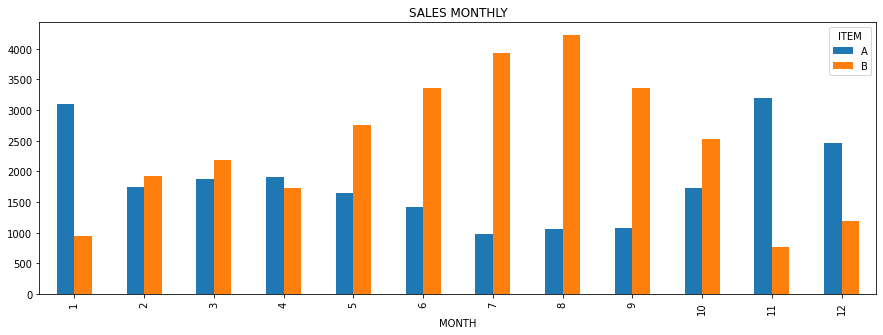

In [ ]:
df_item.plot(kind='bar', figsize=(15,5),  title = 'SALES MONTHLY')     # The best sales of item B is in summer, for itme A is in winter. 

In [ ]:
df.to_csv('df_sales.csv')

**2. Trouver la boutique correspondante**
Tu détermineras à quelle boutique correspond ce fichier de ventes. Pour cela, tu pourras t'aider de données météo. En effet, Bernardo nous a indiqué que les ventes sont corrélées à la météo.
Les boutiques se situent à Bordeaux, Lille, Lyon et Marseille. Tu trouveras les historiques de météo ici pour Bordeaux, Lille, Lyon, et Marseille.

In [ ]:
df_weath_bordeaux=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/bordeaux2019.csv', header = 3, parse_dates=['DATE'])
df_weath_lille=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/lille2019.csv', skiprows = 3, parse_dates=['DATE']) 
df_weath_lyon=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/lyon2019.csv', skiprows = 3, parse_dates=['DATE']) 
df_weath_marseille=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/marseille2019.csv', skiprows = 3, parse_dates=['DATE']) 
    


In [ ]:
df_weath_bordeaux.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    365 non-null    datetime64[ns]
 1   MAX_TEMPERATURE_C       365 non-null    int64         
 2   MIN_TEMPERATURE_C       365 non-null    int64         
 3   WINDSPEED_MAX_KMH       365 non-null    int64         
 4   TEMPERATURE_MORNING_C   365 non-null    int64         
 5   TEMPERATURE_NOON_C      365 non-null    int64         
 6   TEMPERATURE_EVENING_C   365 non-null    int64         
 7   PRECIP_TOTAL_DAY_MM     365 non-null    float64       
 8   HUMIDITY_MAX_PERCENT    365 non-null    int64         
 9   VISIBILITY_AVG_KM       365 non-null    float64       
 10  PRESSURE_MAX_MB         365 non-null    int64         
 11  CLOUDCOVER_AVG_PERCENT  365 non-null    float64       
 12  HEATINDEX_MAX_C         365 non-null    int64     

In [ ]:
# Merge df and 4 cities
df_bordeaux=df.merge(df_weath_bordeaux, how='left', on='DATE')
df_lille=df.merge(df_weath_lille, how='left', on='DATE')
df_lyon=df.merge(df_weath_lyon, how='left', on='DATE')
df_marseille=df.merge(df_weath_marseille, how='left', on='DATE')

In [ ]:
df_bordeaux.to_csv('df_bordeaux.csv')
df_lille.to_csv('df_lille.csv')
df_lyon.to_csv('df_lyon.csv')
df_marseille.to_csv('df_marseille.csv')

In [ ]:
df_bordeaux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 519
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    520 non-null    datetime64[ns]
 1   ITEM                    520 non-null    object        
 2   SALES                   520 non-null    int64         
 3   MONTH                   520 non-null    int64         
 4   WEEKDAY                 520 non-null    int64         
 5   WEEK                    520 non-null    int64         
 6   MAX_TEMPERATURE_C       520 non-null    int64         
 7   MIN_TEMPERATURE_C       520 non-null    int64         
 8   WINDSPEED_MAX_KMH       520 non-null    int64         
 9   TEMPERATURE_MORNING_C   520 non-null    int64         
 10  TEMPERATURE_NOON_C      520 non-null    int64         
 11  TEMPERATURE_EVENING_C   520 non-null    int64         
 12  PRECIP_TOTAL_DAY_MM     520 non-null    float64   

In [ ]:
# Bordeaux: Correlation coefficients for sales(item A) and other variables
df_bordeaux[df_bordeaux['ITEM']=='A'].corr()['SALES'].sort_values(key= abs, ascending=False) 

SALES                     1.000000
MAX_TEMPERATURE_C        -0.746737
HEATINDEX_MAX_C          -0.746466
PRECIP_TOTAL_DAY_MM       0.741453
TEMPERATURE_EVENING_C    -0.730641
TEMPERATURE_NOON_C       -0.726730
SUNHOUR                  -0.717943
WINDTEMP_MAX_C           -0.664779
CLOUDCOVER_AVG_PERCENT    0.657997
MIN_TEMPERATURE_C        -0.635047
HUMIDITY_MAX_PERCENT      0.620117
WEATHER_CODE_EVENING      0.606529
WEATHER_CODE_NOON         0.596221
WEATHER_CODE_MORNING      0.500543
TEMPERATURE_MORNING_C    -0.491502
DEWPOINT_MAX_C           -0.471143
UV_INDEX                 -0.402487
WINDSPEED_MAX_KMH         0.395555
PRESSURE_MAX_MB          -0.353709
VISIBILITY_AVG_KM        -0.221306
WEEKDAY                  -0.036636
WEEK                     -0.025298
MONTH                    -0.017217
TOTAL_SNOW_MM                  NaN
Name: SALES, dtype: float64

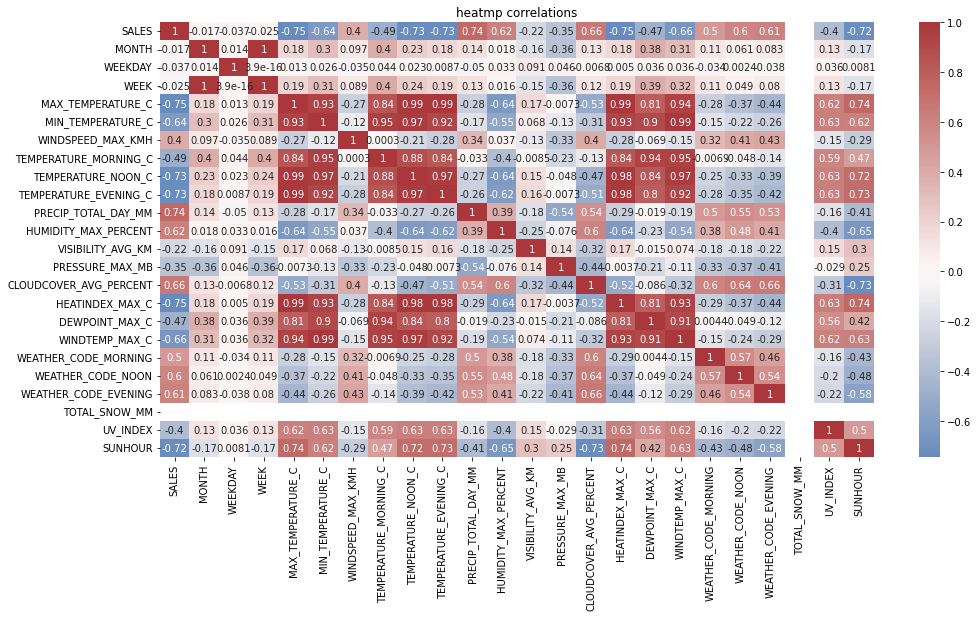

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(df_bordeaux[df_bordeaux['ITEM']=='A'].corr(), cmap="vlag", center=0, annot=True)
plt.title("heatmp correlations")
plt.show()

In [ ]:
# Bordeaux: Correlation coefficients for sales(item B) and other variables
df_bordeaux[df_bordeaux['ITEM']=='B'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
MAX_TEMPERATURE_C         0.880426
HEATINDEX_MAX_C           0.875693
TEMPERATURE_EVENING_C     0.869086
TEMPERATURE_NOON_C        0.854850
WINDTEMP_MAX_C            0.777075
SUNHOUR                   0.766281
MIN_TEMPERATURE_C         0.760657
CLOUDCOVER_AVG_PERCENT   -0.687408
HUMIDITY_MAX_PERCENT     -0.663429
PRECIP_TOTAL_DAY_MM      -0.625089
TEMPERATURE_MORNING_C     0.622416
WEATHER_CODE_EVENING     -0.609637
DEWPOINT_MAX_C            0.591195
WEATHER_CODE_NOON        -0.575278
UV_INDEX                  0.539384
WEATHER_CODE_MORNING     -0.489195
WINDSPEED_MAX_KMH        -0.415888
PRESSURE_MAX_MB           0.252861
VISIBILITY_AVG_KM         0.214905
WEEK                      0.068880
MONTH                     0.061894
WEEKDAY                   0.022429
TOTAL_SNOW_MM                  NaN
Name: SALES, dtype: float64

In [ ]:
# Lille: Correlation coefficients for sales(item A) and other variables
df_lille[df_lille['ITEM']=='A'].corr()['SALES'].sort_values(key= abs, ascending=False)


SALES                     1.000000
TEMPERATURE_EVENING_C    -0.618392
MAX_TEMPERATURE_C        -0.612242
HEATINDEX_MAX_C          -0.606991
TEMPERATURE_NOON_C       -0.604869
WINDTEMP_MAX_C           -0.596868
MIN_TEMPERATURE_C        -0.580081
SUNHOUR                  -0.551740
HUMIDITY_MAX_PERCENT      0.502603
TEMPERATURE_MORNING_C    -0.495269
DEWPOINT_MAX_C           -0.479041
PRESSURE_MAX_MB          -0.476665
CLOUDCOVER_AVG_PERCENT    0.420579
WEATHER_CODE_NOON         0.271799
WEATHER_CODE_MORNING      0.257657
WEATHER_CODE_EVENING      0.255904
PRECIP_TOTAL_DAY_MM       0.247491
VISIBILITY_AVG_KM        -0.227096
TOTAL_SNOW_MM             0.182911
WINDSPEED_MAX_KMH         0.165806
WEEKDAY                  -0.036636
WEEK                     -0.025298
MONTH                    -0.017217
UV_INDEX                       NaN
Name: SALES, dtype: float64

In [ ]:
# Lille: Correlation coefficients for sales(item B) and other variables
df_lille[df_lille['ITEM']=='B'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
TEMPERATURE_EVENING_C     0.743524
HEATINDEX_MAX_C           0.738339
MAX_TEMPERATURE_C         0.736917
TEMPERATURE_NOON_C        0.730789
WINDTEMP_MAX_C            0.722701
MIN_TEMPERATURE_C         0.706320
TEMPERATURE_MORNING_C     0.622289
SUNHOUR                   0.618738
DEWPOINT_MAX_C            0.599929
HUMIDITY_MAX_PERCENT     -0.550135
CLOUDCOVER_AVG_PERCENT   -0.439656
PRESSURE_MAX_MB           0.436416
WEATHER_CODE_NOON        -0.290642
WEATHER_CODE_MORNING     -0.287824
PRECIP_TOTAL_DAY_MM      -0.277163
WEATHER_CODE_EVENING     -0.272040
WINDSPEED_MAX_KMH        -0.207669
VISIBILITY_AVG_KM         0.206286
TOTAL_SNOW_MM            -0.150875
WEEK                      0.068880
MONTH                     0.061894
WEEKDAY                   0.022429
UV_INDEX                       NaN
Name: SALES, dtype: float64

In [ ]:
# Lyon: Correlation coefficients for sales(item A) and other variables
df_lyon[df_lyon['ITEM']=='A'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
TEMPERATURE_EVENING_C    -0.663431
MAX_TEMPERATURE_C        -0.650430
HEATINDEX_MAX_C          -0.649421
UV_INDEX                 -0.644243
SUNHOUR                  -0.635858
TEMPERATURE_NOON_C       -0.619490
WINDTEMP_MAX_C           -0.607084
MIN_TEMPERATURE_C        -0.587497
CLOUDCOVER_AVG_PERCENT    0.583831
DEWPOINT_MAX_C           -0.528639
TEMPERATURE_MORNING_C    -0.503982
HUMIDITY_MAX_PERCENT      0.495265
PRESSURE_MAX_MB          -0.407602
WEATHER_CODE_EVENING      0.361797
PRECIP_TOTAL_DAY_MM       0.320875
WEATHER_CODE_NOON         0.312436
WINDSPEED_MAX_KMH         0.292489
WEATHER_CODE_MORNING      0.250146
VISIBILITY_AVG_KM        -0.223313
TOTAL_SNOW_MM             0.108135
WEEKDAY                  -0.036636
WEEK                     -0.025298
MONTH                    -0.017217
Name: SALES, dtype: float64

In [ ]:
# Lyon: Correlation coefficients for sales(item B) and other variables
df_lyon[df_lyon['ITEM']=='B'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
TEMPERATURE_EVENING_C     0.779996
HEATINDEX_MAX_C           0.765912
MAX_TEMPERATURE_C         0.763528
UV_INDEX                  0.751520
TEMPERATURE_NOON_C        0.737402
WINDTEMP_MAX_C            0.715417
MIN_TEMPERATURE_C         0.713371
SUNHOUR                   0.685861
DEWPOINT_MAX_C            0.670343
TEMPERATURE_MORNING_C     0.640830
CLOUDCOVER_AVG_PERCENT   -0.594899
HUMIDITY_MAX_PERCENT     -0.516906
WEATHER_CODE_EVENING     -0.385609
PRESSURE_MAX_MB           0.329171
WEATHER_CODE_NOON        -0.324328
PRECIP_TOTAL_DAY_MM      -0.286857
WINDSPEED_MAX_KMH        -0.265160
WEATHER_CODE_MORNING     -0.222536
VISIBILITY_AVG_KM         0.191162
TOTAL_SNOW_MM            -0.089810
WEEK                      0.068880
MONTH                     0.061894
WEEKDAY                   0.022429
Name: SALES, dtype: float64

In [ ]:
# Marseille: Correlation coefficients for sales(item A) and other variables
df_marseille[df_marseille['ITEM']=='A'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
TEMPERATURE_EVENING_C    -0.637783
MAX_TEMPERATURE_C        -0.627721
TEMPERATURE_NOON_C       -0.620820
HEATINDEX_MAX_C          -0.614396
SUNHOUR                  -0.606023
WINDTEMP_MAX_C           -0.602083
MIN_TEMPERATURE_C        -0.599409
TEMPERATURE_MORNING_C    -0.546162
CLOUDCOVER_AVG_PERCENT    0.531908
DEWPOINT_MAX_C           -0.439864
PRESSURE_MAX_MB          -0.376933
PRECIP_TOTAL_DAY_MM       0.375482
WEATHER_CODE_NOON         0.365283
HUMIDITY_MAX_PERCENT      0.355307
WINDSPEED_MAX_KMH         0.327251
WEATHER_CODE_MORNING      0.309988
WEATHER_CODE_EVENING      0.308322
VISIBILITY_AVG_KM        -0.120006
WEEKDAY                  -0.036636
WEEK                     -0.025298
MONTH                    -0.017217
TOTAL_SNOW_MM                  NaN
UV_INDEX                       NaN
Name: SALES, dtype: float64

In [ ]:
# Marseille: Correlation coefficients for sales(item B) and other variables
df_marseille[df_marseille['ITEM']=='B'].corr()['SALES'].sort_values(key= abs, ascending=False)

SALES                     1.000000
TEMPERATURE_EVENING_C     0.744258
MAX_TEMPERATURE_C         0.742753
TEMPERATURE_NOON_C        0.741140
HEATINDEX_MAX_C           0.734040
MIN_TEMPERATURE_C         0.730112
WINDTEMP_MAX_C            0.722864
TEMPERATURE_MORNING_C     0.688295
SUNHOUR                   0.640195
DEWPOINT_MAX_C            0.589766
CLOUDCOVER_AVG_PERCENT   -0.515457
WINDSPEED_MAX_KMH        -0.363081
WEATHER_CODE_NOON        -0.337205
HUMIDITY_MAX_PERCENT     -0.321855
PRECIP_TOTAL_DAY_MM      -0.315024
WEATHER_CODE_EVENING     -0.302084
PRESSURE_MAX_MB           0.296562
WEATHER_CODE_MORNING     -0.286586
VISIBILITY_AVG_KM         0.091855
WEEK                      0.068880
MONTH                     0.061894
WEEKDAY                   0.022429
TOTAL_SNOW_MM                  NaN
UV_INDEX                       NaN
Name: SALES, dtype: float64

In [ ]:
# Comparing these 4 citis, i fond Bordeaux has a higher coefficient, so the data is Bordeaux

**3. Explication de l'impact de la météo**
Tu détermineras (par corrélation, ou par Machine Learning) l'importance de chaque dimension. Tu mettras en avant les variables (température, vitesse du vent, etc...) qui semblent les plus corrélées aux ventes, et celles qui sont le moins corrélées. Bernardo a-t-il raison : est-ce bien le vent qui a le plus d'impact sur les ventes ?

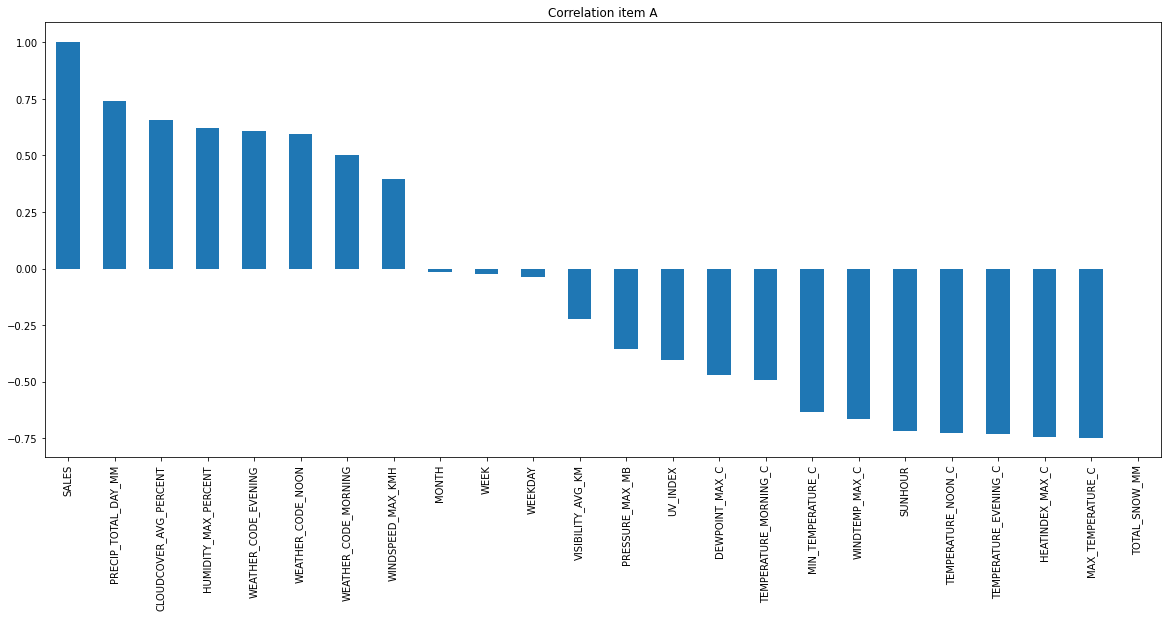

In [ ]:
#For item A
plt.figure(figsize=(20,8))
df_bordeaux[df_bordeaux['ITEM']=='A'].corr()["SALES"].sort_values(ascending=False).plot(kind="bar",title = 'Correlation item A')

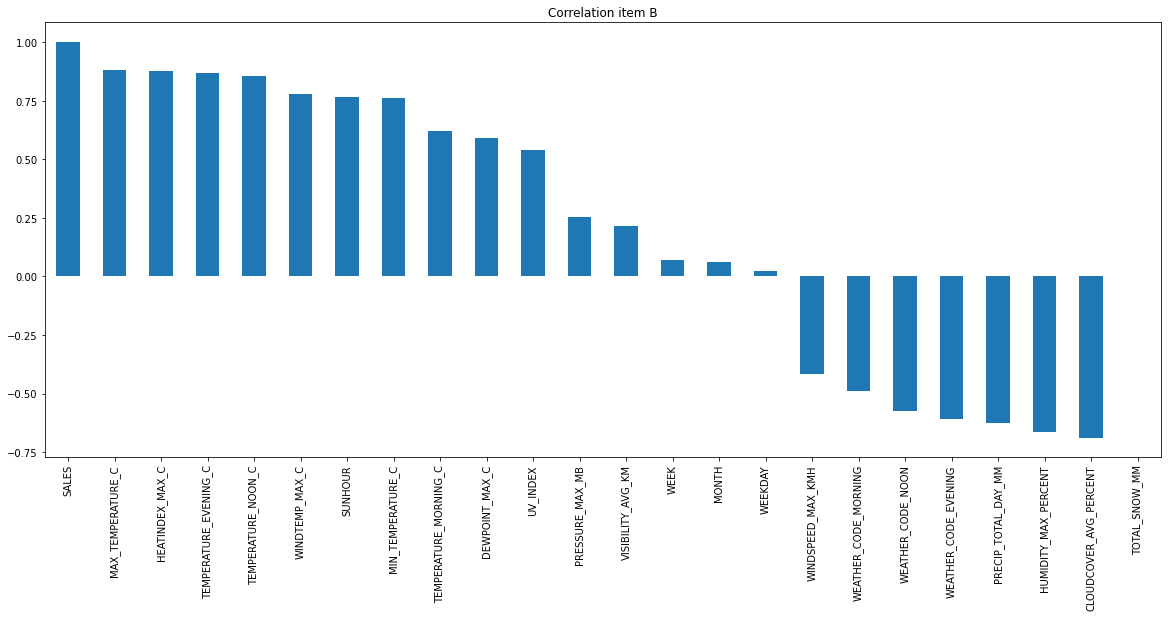

In [ ]:
#For item B
plt.figure(figsize=(20,8))
df_bordeaux[df_bordeaux['ITEM']=='B'].corr()["SALES"].sort_values(ascending=False).plot(kind="bar",title = 'Correlation item B')


**4. Prévisions de ventes**
Bernardo a récupéré des prévisions météo sur une semaine (le fichier est ici). Il aimerait que tu lui fasses une prévision des ventes correspondant à cette période, pour qu'il puisse acheter les bons stocks de produit. Tu devras donc indiquer le stock total minimum que tu conseilles à Bernardo de commander pour la semaine prochaine, afin de pouvoir répondre à la demande, sans faire des sur-stocks.

In [ ]:
df_meteo_juin=pd.read_csv('https://raw.githubusercontent.com/murpi/wilddata/master/test/forecast.csv',parse_dates=['DATE'])
df_meteo_juin

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT
0,2021-06-21,20,14,23,2.0,92,7.0,1025,61.0
1,2021-06-22,25,17,10,0.0,73,9.0,1027,26.0
2,2021-06-23,25,18,19,0.0,79,10.0,1024,19.0
3,2021-06-24,32,23,12,0.0,76,10.0,1018,2.0
4,2021-06-25,28,20,13,1.0,82,10.0,1015,36.0
5,2021-06-26,20,16,19,0.0,88,9.0,1013,89.0
6,2021-06-27,21,15,31,1.0,89,9.0,1015,76.0


In [ ]:
#Because Monday and Tuesday are off, so i use the data from Wednesday to Sundy
df_meteo_juin=df_meteo_juin.loc[2:6]
df_meteo_juin

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT
2,2021-06-23,25,18,19,0.0,79,10.0,1024,19.0
3,2021-06-24,32,23,12,0.0,76,10.0,1018,2.0
4,2021-06-25,28,20,13,1.0,82,10.0,1015,36.0
5,2021-06-26,20,16,19,0.0,88,9.0,1013,89.0
6,2021-06-27,21,15,31,1.0,89,9.0,1015,76.0


In [ ]:
df_meteo_juin['MONTH'] = pd.DatetimeIndex(df_meteo_juin['DATE']).month
df_meteo_juin['WEEKDAY'] = df_meteo_juin['DATE'].dt.day_name()
df_meteo_juin['WEEKDAY']=df_meteo_juin['WEEKDAY'].map({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})
df_meteo_juin['WEEK'] = df_meteo_juin['DATE'].dt.week

<ipython-input-36-974db61c0c72>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['MONTH'] = pd.DatetimeIndex(df_meteo_juin['DATE']).month
<ipython-input-36-974db61c0c72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['WEEKDAY'] = df_meteo_juin['DATE'].dt.day_name()
<ipython-input-36-974db61c0c72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [ ]:
df_meteo_juin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 2 to 6
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    5 non-null      datetime64[ns]
 1   MAX_TEMPERATURE_C       5 non-null      int64         
 2   MIN_TEMPERATURE_C       5 non-null      int64         
 3   WINDSPEED_MAX_KMH       5 non-null      int64         
 4   PRECIP_TOTAL_DAY_MM     5 non-null      float64       
 5   HUMIDITY_MAX_PERCENT    5 non-null      int64         
 6   VISIBILITY_AVG_KM       5 non-null      float64       
 7   PRESSURE_MAX_MB         5 non-null      int64         
 8   CLOUDCOVER_AVG_PERCENT  5 non-null      float64       
 9   MONTH                   5 non-null      int64         
 10  WEEKDAY                 5 non-null      int64         
 11  WEEK                    5 non-null      int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usag

In [ ]:
df_bordeaux['OPINION'].value_counts()

météo défavorable         172
météo favorable           166
météo correcte            106
météo très défavorable     56
météo idéale               20
Name: OPINION, dtype: int64

In [ ]:
# change 'opinion' to numeric

df_bordeaux['OPINION_fac'] = df_bordeaux['OPINION'].factorize()[0]
df_bordeaux['OPINION_fac'].value_counts()

# 0 météo très défavorable     48
# 1 météo défavorable         168
# 2 météo favorable           172
# 3 météo idéale               18
# 4 météo correcte            114

1    172
3    166
2    106
0     56
4     20
Name: OPINION_fac, dtype: int64

In [ ]:
df_bordeaux['TOTAL_SNOW_MM'].mean()

0.0

In [ ]:
df_bordeaux=df_bordeaux.drop(columns='TOTAL_SNOW_MM')


In [ ]:
# Research item A of df of Bordeaux
df_bordeaux_A=df_bordeaux[df_bordeaux['ITEM']=='A']
df_bordeaux_A.head(10)

,DATE,ITEM,SALES,MONTH,WEEKDAY,WEEK,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,...,HEATINDEX_MAX_C,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,UV_INDEX,SUNHOUR,OPINION,OPINION_fac
0,2019-01-02,A,113,1,3,1,9,4,14,5,...,9,3,2,122,116,116,1,8.7,météo très défavorable,0
1,2019-01-03,A,143,1,4,1,7,2,15,1,...,7,0,-2,116,116,116,1,8.7,météo très défavorable,0
2,2019-01-04,A,145,1,5,1,7,1,13,0,...,7,0,-3,113,116,122,1,5.1,météo très défavorable,0
3,2019-01-05,A,167,1,6,1,6,1,9,0,...,6,0,-1,116,116,116,1,8.7,météo très défavorable,0
4,2019-01-06,A,202,1,7,1,5,0,10,-1,...,5,0,-2,143,116,116,1,8.7,météo très défavorable,0
5,2019-01-09,A,146,1,3,2,7,4,12,3,...,7,5,2,143,116,176,1,6.9,météo très défavorable,0
6,2019-01-10,A,202,1,4,2,5,1,14,1,...,5,1,-3,116,116,116,1,8.7,météo très défavorable,0
7,2019-01-11,A,144,1,5,2,7,1,7,0,...,7,3,1,116,119,122,1,3.4,météo très défavorable,0
8,2019-01-12,A,116,1,6,2,9,5,5,5,...,9,5,4,176,119,119,1,3.4,météo très défavorable,0
9,2019-01-13,A,114,1,7,2,10,9,10,9,...,10,9,8,353,176,266,1,3.4,météo défavorable,1


In [ ]:
df_bordeaux_A.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    260 non-null    datetime64[ns]
 1   ITEM                    260 non-null    object        
 2   SALES                   260 non-null    int64         
 3   MONTH                   260 non-null    int64         
 4   WEEKDAY                 260 non-null    int64         
 5   WEEK                    260 non-null    int64         
 6   MAX_TEMPERATURE_C       260 non-null    int64         
 7   MIN_TEMPERATURE_C       260 non-null    int64         
 8   WINDSPEED_MAX_KMH       260 non-null    int64         
 9   TEMPERATURE_MORNING_C   260 non-null    int64         
 10  TEMPERATURE_NOON_C      260 non-null    int64         
 11  TEMPERATURE_EVENING_C   260 non-null    int64         
 12  PRECIP_TOTAL_DAY_MM     260 non-null    float64   

In [ ]:
df_bordeaux_A.to_csv('df_bordeaux_A.csv')

In [ ]:
# For item B
df_bordeaux_B=df_bordeaux[df_bordeaux['ITEM']=='B']
df_bordeaux_B.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 260 to 519
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DATE                    260 non-null    datetime64[ns]
 1   ITEM                    260 non-null    object        
 2   SALES                   260 non-null    int64         
 3   MONTH                   260 non-null    int64         
 4   WEEKDAY                 260 non-null    int64         
 5   WEEK                    260 non-null    int64         
 6   MAX_TEMPERATURE_C       260 non-null    int64         
 7   MIN_TEMPERATURE_C       260 non-null    int64         
 8   WINDSPEED_MAX_KMH       260 non-null    int64         
 9   TEMPERATURE_MORNING_C   260 non-null    int64         
 10  TEMPERATURE_NOON_C      260 non-null    int64         
 11  TEMPERATURE_EVENING_C   260 non-null    int64         
 12  PRECIP_TOTAL_DAY_MM     260 non-null    float64 

In [ ]:
df_bordeaux_B.to_csv('df_bordeaux_B.csv')

In [ ]:
df_meteo_juin.columns

Index(['DATE', 'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'MONTH', 'WEEKDAY',
       'WEEK'],
      dtype='object')

In [ ]:
# train test split for item A (selected the sames columns than df_meteo_juin)
X=df_bordeaux_A[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT','WEEKDAY','MONTH','WEEK']]
y=df_bordeaux_A['SALES']

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42)

In [ ]:
X_train

,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,WEEKDAY,MONTH,WEEK
229,10,7,8,0.0,85,10.000,1010,85.125,7,11,46
246,10,9,26,18.3,93,7.750,1017,96.000,4,12,50
115,17,14,21,15.2,84,14.500,1014,76.625,3,6,24
109,29,25,14,0.0,54,10.000,1017,6.875,7,6,22
111,20,16,15,0.5,68,10.000,1015,72.125,4,6,23
...,...,...,...,...,...,...,...,...,...,...,...
20,9,6,15,4.1,78,10.000,1008,87.000,3,1,5
188,28,21,15,4.0,73,9.500,1012,64.750,6,9,38
71,16,11,14,3.8,79,7.000,1021,59.125,4,4,15
106,24,18,8,0.0,69,9.000,1029,40.375,4,5,22


In [ ]:
# Try with 3 models: LinearRegression; DecisionTreeRegressor; RandomForestRegressor
modelLR = LinearRegression().fit(X_train,y_train)
modelDTR = DecisionTreeRegressor(max_depth = 4).fit(X_train, y_train)  
modelRFR = RandomForestRegressor(max_depth = 4).fit(X_train,y_train)

print("\nLR score train = ",modelLR.score(X_train,y_train))
print("LR score test = ",modelLR.score(X_test,y_test))
print("\nDTR score train = ",modelDTR.score(X_train,y_train))
print("DTR score test = ",modelDTR.score(X_test,y_test))
print("\nRFR score train = ",modelRFR.score(X_train,y_train))
print("RFR score test = ",modelRFR.score(X_test,y_test))


LR score train =  0.8778914874923884
LR score test =  0.8318442025330535

DTR score train =  0.9684775564484217
DTR score test =  0.9421600290684466

RFR score train =  0.9853432652478764
RFR score test =  0.9725765436447503


In [ ]:
# Standardisation (it's no difference after standardization)
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelLR = LinearRegression().fit(X_train_scaled,y_train)
modelDTR = DecisionTreeRegressor(max_depth = 4).fit(X_train_scaled, y_train)
modelRF = RandomForestRegressor(max_depth = 4).fit(X_train_scaled,y_train)

print("Linear Regression:",modelLR.score(X_train_scaled, y_train), modelLR.score(X_test_scaled, y_test))
print("Decision Tree Regression:",modelDTR.score(X_train_scaled, y_train), modelDTR.score(X_test_scaled, y_test))
print("Random Forest Regression:",modelRF.score(X_train_scaled, y_train), modelRF.score(X_test_scaled, y_test))

Linear Regression: 0.8778914874923884 0.8318442025330537
Decision Tree Regression: 0.9684775564484217 0.9183394322835214
Random Forest Regression: 0.9857077859639933 0.9703902155152462


In [ ]:
cross_val_score(LinearRegression(), 
                X, y, 
                cv = 6 )

array([0.28076009, 0.68066444, 0.86263189, 0.5132683 , 0.86305571,
       0.67673222])

In [ ]:
cross_val_score(DecisionTreeRegressor(max_depth = 4), X, y, cv=6)

array([0.47071096, 0.89280658, 0.91502767, 0.89088348, 0.88554212,
       0.72557371])

In [ ]:
cross_val_score(RandomForestRegressor(max_depth = 4), X, y, cv=6)

array([0.41981006, 0.97973512, 0.98197183, 0.93756649, 0.96610588,
       0.82883984])

In [ ]:
moyen_LR =  np.array([0.46254754, 0.76521568, 0.88568647, 0.66553612, 0.90128146,
       0.79273953])
moyen_LR.mean(), np.std(moyen_LR, 0)

(0.7455011333333333, 0.14888290007042176)

In [ ]:
moyen_DTR =  np.array([0.3585758 , 0.90449482, 0.66618211, 0.80968637, 0.79521088,
       0.71416058])
moyen_DTR.mean(), np.std(moyen_DTR, 0)

(0.70805176, 0.17341665330547437)

In [ ]:
moyen_RFR =  np.array([0.39333476, 0.95024563, 0.93062155, 0.92252077, 0.90711803,
       0.81284061])
moyen_RFR.mean(), np.std(moyen_RFR, 0)

(0.8194468916666668, 0.19553079860021733)

In [ ]:
# Sales are affected by seasonality, so it is normal that the score of CV is not good.

In [ ]:
# Méthode RandomizedSearch CV for DTR
dico = {'max_depth' : range(1,11), 
        'min_samples_leaf' : range(1,11),
        'min_samples_split' : [2, 5, 7, 10, 15, 30]}

rando = RandomizedSearchCV(DecisionTreeRegressor(max_depth = 4), dico , n_iter=100)
rando.fit(X,y)

RandomizedSearchCV(estimator=DecisionTreeRegressor(max_depth=4), n_iter=100,
                   param_distributions={'max_depth': range(1, 11),
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': [2, 5, 7, 10, 15,
                                                              30]})

In [ ]:
print("best score:",rando.best_score_)
print("best parameters:",rando.best_params_)
print("best estimator:",rando.best_estimator_)

best score: 0.8557379657325492
best parameters: {'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 6}
best estimator: DecisionTreeRegressor(max_depth=6, min_samples_leaf=3, min_samples_split=5)


In [ ]:
# Méthode RandomizedSearch CV for RFR
dico = {'max_depth' : range(1,11), 
        'min_samples_leaf' : range(1,11),
        'min_samples_split' : [2, 5, 7, 10, 15, 30]}

rando = RandomizedSearchCV(RandomForestRegressor(), dico , n_iter=100)
rando.fit(X,y)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': range(1, 11),
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': [2, 5, 7, 10, 15,
                                                              30]})

In [ ]:
print("best score:",rando.best_score_)
print("best parameters:",rando.best_params_)
print("best estimator:",rando.best_estimator_)

best score: 0.8742385609277088
best parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9}
best estimator: RandomForestRegressor(max_depth=9, min_samples_leaf=2)


In [ ]:
# I choose model Random Forest regression for the sales prediction (item A), because it is the best in comparison
df_bordeaux_A['PREDICT']=modelRFR.predict(X)
df_bordeaux_A

<ipython-input-64-69a70e00758f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bordeaux_A['PREDICT']=modelRFR.predict(X)


,DATE,ITEM,SALES,MONTH,WEEKDAY,WEEK,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,TEMPERATURE_MORNING_C,...,DEWPOINT_MAX_C,WINDTEMP_MAX_C,WEATHER_CODE_MORNING,WEATHER_CODE_NOON,WEATHER_CODE_EVENING,UV_INDEX,SUNHOUR,OPINION,OPINION_fac,PREDICT
0,2019-01-02,A,113,1,3,1,9,4,14,5,...,3,2,122,116,116,1,8.7,météo très défavorable,0,108.610552
1,2019-01-03,A,143,1,4,1,7,2,15,1,...,0,-2,116,116,116,1,8.7,météo très défavorable,0,148.796350
2,2019-01-04,A,145,1,5,1,7,1,13,0,...,0,-3,113,116,122,1,5.1,météo très défavorable,0,147.913350
3,2019-01-05,A,167,1,6,1,6,1,9,0,...,0,-1,116,116,116,1,8.7,météo très défavorable,0,167.996905
4,2019-01-06,A,202,1,7,1,5,0,10,-1,...,0,-2,143,116,116,1,8.7,météo très défavorable,0,176.573496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2019-12-25,A,76,12,3,52,13,11,10,11,...,11,10,143,143,116,1,8.7,météo correcte,2,84.304078
256,2019-12-26,A,82,12,4,52,13,11,14,11,...,9,10,119,116,176,1,6.9,météo correcte,2,84.927104
257,2019-12-27,A,76,12,5,52,13,9,7,8,...,9,8,116,116,116,1,8.7,météo correcte,2,83.414307
258,2019-12-28,A,101,12,6,52,10,7,10,8,...,8,6,143,116,122,1,6.9,météo défavorable,1,92.550886


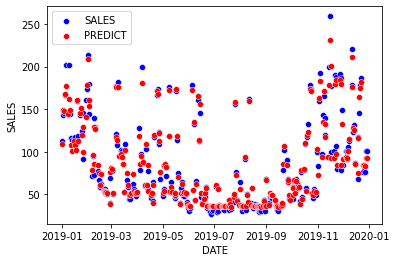

In [ ]:
sns.scatterplot(data=df_bordeaux_A, x='DATE', y='SALES', label ='SALES',color='blue')
sns.scatterplot(data=df_bordeaux_A, x='DATE', y='PREDICT', color='red',label ='PREDICT')

In [ ]:
df_bordeaux_A.to_csv('df_bordeaux_A_pred.csv')

In [ ]:
# Sales prediction for itme A for from 2021-06-23 to 2021-06-27
X=df_meteo_juin[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'WEEKDAY','MONTH','WEEK']]
df_meteo_juin['PREDICT_A']=modelRFR.predict(X)


<ipython-input-67-19e938fdfacf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['PREDICT_A']=modelRFR.predict(X)


In [ ]:
df_meteo_juin

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,MONTH,WEEKDAY,WEEK,PREDICT_A
2,2021-06-23,25,18,19,0.0,79,10.0,1024,19.0,6,3,25,38.360618
3,2021-06-24,32,23,12,0.0,76,10.0,1018,2.0,6,4,25,35.744962
4,2021-06-25,28,20,13,1.0,82,10.0,1015,36.0,6,5,25,45.374834
5,2021-06-26,20,16,19,0.0,88,9.0,1013,89.0,6,6,25,53.946821
6,2021-06-27,21,15,31,1.0,89,9.0,1015,76.0,6,7,25,61.568384


In [ ]:
# train test split for item A (selected the sames columns than df_meteo_juin)
X=df_bordeaux_B[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT','WEEKDAY','MONTH','WEEK']]
y=df_bordeaux_B['SALES']

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,random_state=42)

In [ ]:
modelLR = LinearRegression().fit(X_train,y_train)
modelDTR = DecisionTreeRegressor(max_depth = 4).fit(X_train, y_train)  
modelRFR = RandomForestRegressor(max_depth = 4).fit(X_train,y_train)

print("\nLR score train = ",modelLR.score(X_train,y_train))
print("LR score test = ",modelLR.score(X_test,y_test))
print("\nDTR score train = ",modelDTR.score(X_train,y_train))
print("DTR score test = ",modelDTR.score(X_test,y_test))
print("\nRFR score train = ",modelRFR.score(X_train,y_train))
print("RFR score test = ",modelRFR.score(X_test,y_test))


LR score train =  0.9425123923608087
LR score test =  0.9289185857551117

DTR score train =  0.9612585695508744
DTR score test =  0.9414362059523242

RFR score train =  0.9738536245951723
RFR score test =  0.9603311003882335


In [ ]:
# Sales prediction for itme B for from 2021-06-23 to 2021-06-27.
X=df_meteo_juin[['MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'WEEKDAY','MONTH','WEEK']]
df_meteo_juin['PREDICT_B']=modelRFR.predict(X)

<ipython-input-72-8a895392b7f5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['PREDICT_B']=modelRFR.predict(X)


In [ ]:
df_meteo_juin

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,MONTH,WEEKDAY,WEEK,PREDICT_A,PREDICT_B
2,2021-06-23,25,18,19,0.0,79,10.0,1024,19.0,6,3,25,38.360618,177.148258
3,2021-06-24,32,23,12,0.0,76,10.0,1018,2.0,6,4,25,35.744962,211.111208
4,2021-06-25,28,20,13,1.0,82,10.0,1015,36.0,6,5,25,45.374834,190.961834
5,2021-06-26,20,16,19,0.0,88,9.0,1013,89.0,6,6,25,53.946821,125.343194
6,2021-06-27,21,15,31,1.0,89,9.0,1015,76.0,6,7,25,61.568384,121.016195


In [ ]:
df_meteo_juin['PREDICT_A']=df_meteo_juin['PREDICT_A'].astype(int)

<ipython-input-74-05fb2a0cb400>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['PREDICT_A']=df_meteo_juin['PREDICT_A'].astype(int)


In [ ]:
df_meteo_juin['PREDICT_B']=df_meteo_juin['PREDICT_B'].astype(int)

<ipython-input-75-5449e1f8259c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo_juin['PREDICT_B']=df_meteo_juin['PREDICT_B'].astype(int)


In [ ]:
df_meteo_juin

,DATE,MAX_TEMPERATURE_C,MIN_TEMPERATURE_C,WINDSPEED_MAX_KMH,PRECIP_TOTAL_DAY_MM,HUMIDITY_MAX_PERCENT,VISIBILITY_AVG_KM,PRESSURE_MAX_MB,CLOUDCOVER_AVG_PERCENT,MONTH,WEEKDAY,WEEK,PREDICT_A,PREDICT_B
2,2021-06-23,25,18,19,0.0,79,10.0,1024,19.0,6,3,25,38,177
3,2021-06-24,32,23,12,0.0,76,10.0,1018,2.0,6,4,25,35,211
4,2021-06-25,28,20,13,1.0,82,10.0,1015,36.0,6,5,25,45,190
5,2021-06-26,20,16,19,0.0,88,9.0,1013,89.0,6,6,25,53,125
6,2021-06-27,21,15,31,1.0,89,9.0,1015,76.0,6,7,25,61,121


In [ ]:
df_meteo_juin.to_csv('df_meteo_juin.csv')

In [ ]:
# stocks prediction final
df_predict=df_meteo_juin[['DATE','PREDICT_A', 'PREDICT_B']]
df_predict

,DATE,PREDICT_A,PREDICT_B
2,2021-06-23,38,177
3,2021-06-24,35,211
4,2021-06-25,45,190
5,2021-06-26,53,125
6,2021-06-27,61,121


In [ ]:
df_predict.to_csv('df_predict.csv')